# 2. Model Building

We have a dataset ready to be worked with. Using the pickle we created, we will now try with several different predicting models to see which ones gives us the best results.

In [6]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import re
import math
import os
import pickle
import pprint
from IPython.display import display, Markdown, Latex
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.model_selection import *
import warnings
from sklearn import preprocessing
from sklearn import utils


#models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# ensemble models
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import VotingClassifier

if not os.path.isdir('data'):
    os.mkdir('data')
if not os.path.isdir('models'):
    os.mkdir('models')

## 2.1. Basic model training

We will now start modeling our data. Our first step will be to choose among the most common classifiers and perform a basic model with our data.

Let's load the previously pre-processed data from the pickle in order to work on it. 

In [18]:
with open('data/train_test.pickle', 'rb') as file:
    dataset_list = pickle.load(file)
    
X_train = dataset_list[0]
X_test = dataset_list[1]
y_train = dataset_list[2]
y_test = dataset_list[3]

The models we will be trying are:
- Logistic Regression
- K-Neighbors Classifier
- Decision Tree Classifier
- XGBoost
- Random Forest Classifier

In [19]:
num_folds = 10
seed = 1
scoring = 'roc_auc'
model_names = ['Logistic Regression', 'K-Neighbors Classifier', 'Decision Tree Classifier', 'XGBoost', 'Random Forest' ]
models = []
# basic models
models.append((model_names[0], LogisticRegression()))
models.append((model_names[1], KNeighborsClassifier()))
models.append((model_names[2], DecisionTreeClassifier()))

# ensemble models
models.append((model_names[3], XGBClassifier(use_label_encoder=False,eval_metric='auc')))
models.append((model_names[4], RandomForestClassifier()))

# KFolds for model selection:
table_results = []
basic_results = {}
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for name, model in tqdm(models):
        kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        table_results.append([name,cv_results.mean(),cv_results.std()])
        basic_results[name] = cv_results.mean()

pd.DataFrame(table_results, columns=['Model', 'Mean', 'Std']).sort_values(by = ['Mean'], ascending=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.12s/it]


,Model,Mean,Std
3,XGBoost,0.959365,0.003124
4,Random Forest,0.956494,0.002893
0,Logistic Regression,0.951391,0.003934
1,K-Neighbors Classifier,0.941496,0.004220
2,Decision Tree Classifier,0.865726,0.007224


We see that we get really good results for most of the models, except for the decision tree classifier, that only gives around 86% accuracy (the next best one is already at 94% accuracy). For this reason we will not be further using the Decision Tree Classifier.

In [20]:
#removing the Decision tree classifier from our list of models
if(models[2][0] == 'Decision Tree Classifier'):
    del(models[2])

## 2.2. Feature importance for the best models

#### Feature importance for XGBoost Classifier

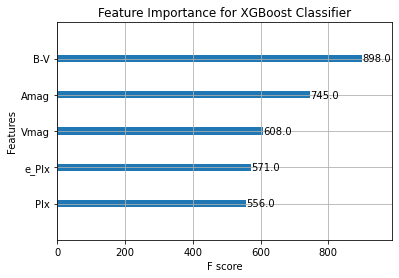

In [21]:
xgb_clf = models[2][1].fit(X_train, y_train)
xgb.plot_importance(booster=xgb_clf, title='Feature Importance for XGBoost Classifier');

#### Feature importance for Random Forest Classifier

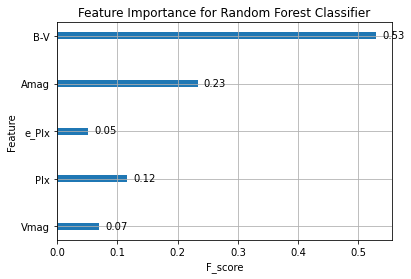

In [22]:
rf_clf = models[3][1].fit(X_train, y_train)

x_axis = X_train.columns
y_axis = rf_clf.feature_importances_
plt.barh(x_axis, y_axis, height=0.15)
plt.title('Feature Importance for Random Forest Classifier')
plt.ylabel('Feature')
plt.xlabel('F_score')
plt.grid()
for i, v in enumerate(y_axis):
    plt.text(v+0.01, i-0.05, str(round(v, 2)), color='black')
plt.show()

#### Feature importance for Logistic Regression Classifier

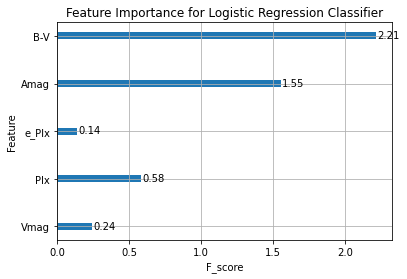

In [23]:
lr_clf = models[0][1].fit(X_train, y_train)

x_axis = X_train.columns
y_axis = abs(lr_clf.coef_[0])
plt.barh(x_axis, y_axis, height=0.15)
plt.title('Feature Importance for Logistic Regression Classifier')
plt.ylabel('Feature')
plt.xlabel('F_score')
plt.grid()
for i, v in enumerate(y_axis):
    plt.text(v+0.01, i-0.05, str(round(v, 2)), color='black')
plt.show()

From the three plots, we can certainly conclude that the star's color plays the biggest role when it comes to classifiying the stars, as well as the absolute magnitude, as we could have expected. The distance from Earth and the apparent visual magnitude seem to not be so important. That would make sense, since how far from us a star is has nothing to do with how big or small it is. Similarly, the apparent magnitude we see form Earth doesn't determine its size. 

The next question is: would our models classify better if we removed the three variables that are not so improtant? Let's try it.

In [24]:
X_train_fi = X_train.drop(['Vmag', 'Plx', 'e_Plx'], axis=1)

# KFolds for model selection:
table_results = []
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for name, model in tqdm(models):
        kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
        cv_results = cross_val_score(model, X_train_fi, y_train, cv=kfold, scoring=scoring)
        table_results.append([name,cv_results.mean(),cv_results.std()])

pd.DataFrame(table_results, columns=['Model', 'Mean', 'Std']).sort_values(by = ['Mean'], ascending=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:43<00:00, 10.85s/it]


,Model,Mean,Std
2,XGBoost,0.955922,0.003188
0,Logistic Regression,0.951288,0.004040
3,Random Forest,0.948011,0.003807
1,K-Neighbors Classifier,0.938777,0.003282


This change made the mean for all the classifying values worse than they were before. Thus, we will keep all the variables just as we had before. 

## 2.3. Hyperparameter tuning

We will now tune the best three models we found,i.e. XGBoost, Logistic Regression and Random Forest. To do so, we will create a grid with a few possible values to pass as arguments to the model. Then, we'll try the results with each combination of parameters, and by comparison, choose the one that yields the best results. For that we will use a grid search (trying all the combinations from the grid we created). 

### 2.3.1. XGBoost Hypertuning

In [16]:
param_grid = {'max_depth': [max_depth for max_depth in range(5,10)],
               'min_child_weight': [min_child_weight for min_child_weight in range(5,10)],
               'eta': [.5, .4, .3, .2, .1, .05, .01, .005],
              }

xgbc = GridSearchCV(estimator = XGBClassifier(use_label_encoder=False,eval_metric='auc', objective='reg:squarederror'), param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1, scoring=scoring)

hypertuned_xgb = xgbc.fit(X_train, y_train)
print(f"After the hyperparameter tuning, the best score achieved has been {hypertuned_xgb.best_score_}.")
hypertuning_results['XGBoost']= hypertuned_xgb.best_score_

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
After the hyperparameter tuning, the best score achieved has been 0.9616300617164351.


We have accomplished a better result than the original one we had with the new parameters. We will save this model so that we can have acces to it later. 

In [17]:
if not os.path.isdir('models'):
    os.mkdir('models')

with open('models/hypertuned_xgbc.pickle', 'wb') as file:
    pickle.dump(hypertuned_xgb, file)dc

### 2.3.2. Random Forest hyperparameter tuning 

In [17]:
# Create the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)],
               'max_features': ['auto', 'sqrt'],
               'min_samples_split': [2, 7],
               'min_samples_leaf': [1, 3],
               'bootstrap': [True, False]
              }

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv = 5, verbose=2, n_jobs=-1, scoring=scoring)
# Fit the random search model
hypertuned_rf = rf_random.fit(X_train, y_train)

print(f"After the hyperparameter tuning, the best score achieved has been {hypertuned_rf.best_score_}.")
hypertuning_results['Random Forest']= hypertuned_rf.best_score_

Fitting 5 folds for each of 80 candidates, totalling 400 fits
After the hyperparameter tuning, the best score achieved has been 0.9589651535569805.


In [18]:
with open('models/hypertuned_rf.pickle', 'wb') as file:
    pickle.dump(hypertuned_rf, file)

### 2.3.3. Logistic Regression Hypertuning

In [19]:
from sklearn.pipeline import Pipeline
# Create first pipeline for base without reducing features.
pipe = Pipeline([('classifier' , LogisticRegression())])

# Create param grid.
param_grid = [
    {'classifier__C' : np.logspace(-4, 4, 20),
     'classifier__fit_intercept' : [True, False],
     'classifier__class_weight' : [dict, 'balanced'],
     'classifier__solver' : ['newton-cg', 'lbfgs', 'sag', 'saga']}
]

# Create grid search object
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1, scoring=scoring)

# Fit on data
hypertuned_logreg = clf.fit(X_train, y_train)

print(f"After the hyperparameter tuning, the best score achieved has been {hypertuned_logreg.best_score_}.")
hypertuning_results['Logistic Regression']= hypertuned_logreg.best_score_

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
After the hyperparameter tuning, the best score achieved has been 0.9516406426340046.


We have now successfully found the best parameters for the Logistic regression model as well. We'll save it, as we did with with the XGBosst classifier.

In [19]:
with open('models/hypertuned_logreg.pickle', 'wb') as file:
    pickle.dump(hypertuned_logreg, file)

## 2.4. Ensemble Model

Let's have an overview of what we have done so far. We have considered 5 differents models, of which we discarded one for not having results as good as the others. We have then tuned the parameters of the best three of the remaining models as to get the highest Area Under the Curve possible. Now, as our final step before analysing the results, we will make an ensemble model. That means we will take the three hypertuned models, and we will combine them in one single `Voting Classifier Model`. This will take the results of each model and through an *election* decide which class to predict.

In [39]:
model_names.append('Ensemble')
estimators = [('xgb', hypertuned_xgb), ('rf', hypertuned_rf), ('lr', hypertuned_logreg)]#, ('knn', hypertuned_knn)]
voting_clf_ = VotingClassifier(estimators=estimators, voting='soft')

In [40]:
kfold = KFold(n_splits=5, random_state=0, shuffle=True)
cv_results = cross_val_score(voting_clf_, X_train, y_train, cv=kfold, scoring='roc_auc')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits


C:\Users\marta\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.94965936 0.94965936        nan 0.94965923 0.94965786 0.94962292
 0.94962289        nan 0.94962332 0.9496231  0.94972737 0.94972694
 0.94971966 0.94972728 0.94972749 0.94971559 0.94971553 0.9497155
 0.94971633 0.94971553 0.95028347 0.9502835         nan 0.95028329
 0.95028326 0.9501416  0.95014157        nan 0.95014157 0.9501413
 0.95037753 0.95037747 0.95036064 0.95037737 0.95037734 0.95034152
 0.95034155 0.95034164 0.95034167 0.95034142 0.95041035 0.95041035
        nan 0.95041014 0.95041056 0.95013584 0.95013584        nan
 0.95013618 0.95013615 0.95054173 0.95054145 0.95052371 0.95054136
 0.95054054 0.95048189 0.95048182 0.95048201 0.95048097 0.9504814
 0.95043613 0.95043604        nan 0.95043705 0.95043616 0.95009802
 0.95009802        nan 0.95009826 0.95009759 0.95058012 0.95058012
 0.95057528 0.95058064 0.9505796  0.95055387 0.95055381 

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits


C:\Users\marta\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.95167784 0.95167784        nan 0.95167692 0.95167735 0.95166973
 0.95166943        nan 0.95167041 0.95166961 0.95173337 0.95173208
 0.95173273 0.95173263 0.95173318 0.95173193 0.9517319  0.95173193
 0.95172979 0.95173129 0.95231642 0.95231648        nan 0.95231593
 0.95231572 0.95219371 0.95219362        nan 0.95219497 0.95219423
 0.95240624 0.95240637 0.95238669 0.95240621 0.95240569 0.95237012
 0.95237012 0.95237055 0.95237    0.95237043 0.95245459 0.95245459
        nan 0.95245358 0.95245422 0.95219731 0.95219731        nan
 0.95219734 0.95219798 0.95257363 0.9525735  0.95255291 0.95257378
 0.95257375 0.95250832 0.95250825 0.95250804 0.95250911 0.95250819
 0.95246659 0.95246656        nan 0.95246662 0.95246683 0.95214831
 0.95214825        nan 0.95214801 0.95214761 0.95258673 0.95258673
 0.95258062 0.95258667 0.95258682 0.95255718 0.952557

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits


C:\Users\marta\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.95041237 0.95041234        nan 0.95041212 0.95041218 0.95038965
 0.95038974        nan 0.9503899  0.9503895  0.9504723  0.95047236
 0.95046769 0.95047297 0.95047303 0.95046378 0.95046366 0.95046341
 0.9504632  0.95046265 0.95110175 0.95110193        nan 0.95110111
 0.95110096 0.95096077 0.9509608         nan 0.95096061 0.95095991
 0.95119071 0.95119068 0.95117209 0.95119099 0.95119068 0.95115365
 0.95115362 0.9511539  0.95115393 0.95115271 0.9512757  0.9512757
        nan 0.9512753  0.95127551 0.95101235 0.95101235        nan
 0.95101208 0.95101263 0.9513947  0.95139479 0.95137361 0.95139467
 0.9513951  0.95132732 0.95132742 0.95132778 0.95132626 0.95132745
 0.95130905 0.95130908        nan 0.9513095  0.95130892 0.95099417
 0.95099411        nan 0.95099441 0.95099362 0.95143809 0.95143816
 0.95143205 0.95143812 0.95143773 0.95140573 0.9514058

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits


C:\Users\marta\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.95055131 0.95055125        nan 0.95055204 0.95055155 0.95052243
 0.9505224         nan 0.95052319 0.95052307 0.9506091  0.95060864
 0.95060363 0.95060922 0.95060833 0.95060014 0.95060008 0.95059996
 0.95060027 0.95060097 0.95116754 0.95116757        nan 0.95116739
 0.95116748 0.95103179 0.9510317         nan 0.9510324  0.95103158
 0.9512569  0.95125693 0.95124079 0.95125699 0.95125681 0.95122646
 0.95122646 0.95122606 0.95122622 0.95122683 0.95129192 0.95129213
        nan 0.95129201 0.9512921  0.95103123 0.95103126        nan
 0.95103163 0.95103157 0.95140786 0.95140786 0.95139069 0.95140786
 0.95140765 0.95135481 0.95135481 0.9513549  0.95135447 0.95135509
 0.95128684 0.95128687        nan 0.95128659 0.95128653 0.95097521
 0.95097509        nan 0.95097509 0.95097417 0.95141452 0.95141452
 0.9514125  0.95141547 0.95141477 0.95139438 0.951394

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits


C:\Users\marta\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.9497718  0.94977177        nan 0.94977217 0.94977147 0.94974637
 0.94974634        nan 0.94974506 0.94974631 0.94983015 0.94982933
 0.94982502 0.94982994 0.9498304  0.94982156 0.94982144 0.94982111
 0.94982153 0.94982141 0.95049102 0.95049102        nan 0.9504909
 0.95049075 0.95035635 0.95035635        nan 0.95035647 0.95035644
 0.95058449 0.95058446 0.95056697 0.95058327 0.95058446 0.95054919
 0.95054912 0.95054922 0.95054919 0.95054937 0.9507226  0.95072266
        nan 0.95072238 0.95072244 0.95045601 0.95045601        nan
 0.95045543 0.95045546 0.95084418 0.95084409 0.95082294 0.95084373
 0.9508436  0.95078388 0.95078382 0.95078406 0.95078437 0.95078425
 0.95078118 0.95078118        nan 0.95078002 0.9507813  0.9504578
 0.95045774        nan 0.95045786 0.95045731 0.95091973 0.95091973
 0.95091203 0.9509197  0.95091939 0.95088424 0.95088421

Ensemble: Mean: 0.960720758414304 Std: 0.002306849328364128


In [ ]:
print("Ensemble: Mean: {:>8} Std: {:>8}".format(cv_results.mean(), cv_results.std()))

**Output:** Ensemble: Mean: 0.960720758414304 Std: 0.002306849328364128

Finally, let's train and save the ensemble model in a pickle file.

In [7]:
voting_clf_trained = voting_clf_.fit(X_train, y_train)

# predict test set
# y_pred = voting_clf_.predict(X_test)

with open('models/voting_clf.pickle', 'wb') as file:
    pickle.dump(voting_clf_trained, file)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits


C:\Users\marta\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\marta\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.95063385 0.95063389        nan 0.95063395 0.95063383 0.95059184
 0.95059176        nan 0.95059193 0.95059246 0.95069785 0.95069758
 0.95069267 0.95069834 0.95069754 0.95068766 0.95068764 0.95068746
 0.95068786 0.95068733 0.95114737 0.95114741        nan 0.95114799
 0.95114745 0.95097755 0.95097766        nan 0.95097745 0.950978
 0.95124417 0.95124415 0.95122451 0.95124444 0.9512439  0.95120071
 0.95120075 0.95120071 0.95120028 0.95120049 0.95124578 0.95124609
        nan 0.95124547 0.95124599 0.95095713 0.95095727        nan
 0.95095719 0.9509568  0.95137069 0.95137088 0.95135527 0.95137067
 0.95

NameError: name 'classification_report' is not defined

## 2.5. Model Comparison

In [15]:
with open('models/hypertuned_xgbc.pickle', 'rb') as file:
    hypertuned_xgb = pickle.load(file)
with open('models/hypertuned_rf.pickle', 'rb') as file:
    hypertuned_rf = pickle.load(file)
with open('models/hypertuned_logreg.pickle', 'rb') as file:
    hypertuned_logreg = pickle.load(file)
with open('models/voting_clf.pickle', 'rb') as file:
    voting_clf = pickle.load(file)
    
train_results = {}
train_results['XGBoost'] = hypertuned_xgb.best_score_
train_results['Random Forest'] = hypertuned_rf.best_score_
train_results['Logistic Regression'] = hypertuned_logreg.best_score_
train_results['Ensemble'] = cv_results.mean()

In [25]:
comparative_table = []
for name in model_names:
    if name not in basic_results.keys():
        basic_results[name] = "--"
    comparative_table.append([name, basic_results[name], train_results[name]])

models_comparative = pd.DataFrame(comparative_table, columns=['Model Name', 'AUC Before Tuning', 'AUC After Tuning'])
models_comparative.sort_values(by=['AUC After Tuning'], ascending=False)

,Model Name,AUC Before Tuning,AUC After Tuning
0,XGBoost,0.959365,0.961630
3,Ensemble,--,0.960721
1,Random Forest,0.956494,0.958965
2,Logistic Regression,0.951391,0.951641


We see that, in the end, the ensemble model didn't give us better results (at least not in training) than all the rest. In this case the XGBoost Classifier is the one with the best training results. That means that the Random Forest and the Logistic Regression vote don't help the classification. 

In short: the best result in training we could find is obtained using the XGBoost model after tuning it's best parameters, which are:
    
    eta = 0.05
    max_depth = 5
    min_child_weight = 8

(they can be printed using `hypertuned_xgb.best_params_`)

# 3. Model testing

Once we have trained all of our models (these were Logistic Regression, XGBoost, Random Forest and a voting ensemble of the three), let's make a prediction with our test data to really see which one will be better in the end.

In [28]:
# prediction vectors for both train and test
y_pred_log_reg_train = hypertuned_logreg.predict(X_train)
y_pred_log_reg_test = hypertuned_logreg.predict(X_test)

y_pred_xgboost_train = hypertuned_xgb.predict(X_train)
y_pred_xgboost_test = hypertuned_xgb.predict(X_test)

y_pred_rf_train = hypertuned_rf.predict(X_train)
y_pred_rf_test = hypertuned_rf.predict(X_test)

y_pred_ensemble_train = voting_clf_.predict(X_train)
y_pred_ensemble_test = voting_clf_.predict(X_test)

train_predictions = {'Logistic Regression' : y_pred_log_reg_train,
                     'XGBoost' : y_pred_xgboost_train,
                     'Random Forest' : y_pred_rf_train,
                     'Ensemble' : y_pred_ensemble_train}

test_predictions = {'Logistic Regression' : y_pred_log_reg_test,
                     'XGBoost' : y_pred_xgboost_test,
                     'Random Forest' : y_pred_rf_test,
                     'Ensemble' : y_pred_ensemble_test}

Let's first try to use the `classification_report` function from `sklearn`. 

In [32]:
for model in model_names:
    print(f"The classification report for {name} is:")
    print(classification_report(test_predictions[model], y_test))

The classification report for {name} is:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      4658
           1       0.89      0.93      0.91      3392

    accuracy                           0.92      8050
   macro avg       0.92      0.92      0.92      8050
weighted avg       0.92      0.92      0.92      8050

The classification report for {name} is:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      4634
           1       0.89      0.93      0.91      3416

    accuracy                           0.92      8050
   macro avg       0.92      0.92      0.92      8050
weighted avg       0.92      0.92      0.92      8050

The classification report for {name} is:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      4605
           1       0.89      0.93      0.91      3445

    accuracy                           0.92      8050
   ma

Strikingly, we get the exact same results for all of them. Let's see if we can see this metrics with a little bit more precision. 

In [36]:
def accuracy(pred, test):
    return sum([1 if pred[i] == test[idx] else 0 for i,idx in enumerate(test.index)])/len(test)

for model in model_names:
    print(f"The accuracy using {model} is {accuracy(test_predictions[model], y_test)}.")


The accuracy using XGBoost is 0.9222360248447204.
The accuracy using Random Forest is 0.9214906832298136.
The accuracy using Logistic Regression is 0.9198757763975155.
The accuracy using Ensemble is 0.9219875776397516.


Meaning the results are really similar, regardless of the model, when we use the prediction metric. The best one is still the XGBoost classifier.

To wrap it all up, let's save the prediction results in a pickle file as well, so that we can just acces them, if ever we need to. 

In [10]:
# saving train and test predictions
with open('predictions/train_predictions.pickle', 'wb') as file:
    pickle.dump(train_predictions, file)

with open('predictions/test_predictions.pickle', 'wb') as file:
    pickle.dump(test_predictions, file)


# 4. Conclusions and Future Work

This dataset gave really good results from the beggining, even before we tuned or models or used the ensemble model. Even then, it was still a really workable and flexible dataset that offered room for new variables to work with.

I order to improve this classification, there are a couple things we could do. In terms of approach, we could try to create a model that would not only classify between dwarf and giants, but also specify further and determine the type of dwarf or the type of giant that the star is actually classified as. 

In terms of modeling, we could have tried our models with a different preprocessed data (for example with min-max normalization instead of 0 to 1). It would also be a good idea to find the best parameters for the `N-Neighbours Clasifier` and add it to the voting ensemble, although the results would probably be the same or insignicantly different. Lastly, we could have tried with a different type of ensemble; we tried with a *soft* voting system, meaning  that the final decision was made using the average score for all models. We could have tried a *hard* voting system to potencially get different results.

As well, we could have tried more models, although that improvement offers a list of possibilities that would never end. 

In the end, this dataset was easy to work with and has been really helpful to learn more about classification models.